<a href="https://colab.research.google.com/github/kritiyer/mydeeplabdemo/blob/master/CritikAlNet_v3.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#@title link necessary files

from google.colab import drive

drive.mount('/content/gdrive')

%cd '/content/gdrive/My Drive/CritikAlNet demo/'

%ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/CritikAlNet demo
best_images.zip  Combined_Network_V7.h5  goodimages/  model.py  __pycache__/


In [6]:
#@title Python Imports

import os
from io import BytesIO
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import unsharp_mask
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model import preprocess_input
from PIL import Image

print(tf.__version__)

1.15.0


In [7]:
#@title create Deeplab model and load weights

#create model instance

def create_model():
  from model import Deeplabv3
  from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, BatchNormalization
  from tensorflow.keras.models import Sequential, Model
  inputs = Input(shape=(512, 512, 1))

  activation_func = None
  X1 = Conv2D(1, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(inputs)
  X2 = Conv2D(1, (3,3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X1)
  X3 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X2)
  X4 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X3)
  X5 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X4)
  X6 = Conv2D(1, (3,3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation='tanh', 
              use_bias=False, data_format="channels_last")(X5)
  X7 = tf.keras.layers.concatenate([X6, X6, X6], axis=3)  

  unsharp_mask_model = Model(inputs=inputs, outputs=X7)
  deeplab_model = Deeplabv3(weights=None,backbone='xception',input_shape=(512,512,3), classes=2)

  combined_inputs = Input(shape=(512, 512, 1))
  unsharp_mask_img = unsharp_mask_model(combined_inputs)
  deeplab_img = deeplab_model(unsharp_mask_img)
  model = Model(combined_inputs,deeplab_img)

  return model

model = create_model()
model.load_weights('Combined_Network_V7.h5')
print('model loaded successfully!')

model loaded successfully!


# **Run on sample images**

In [8]:
#@title Create data pipeline
def label_preprocess(image):
  x = image==1
  x = x.astype('float32')
  return x

data_gen_args = dict(preprocessing_function = preprocess_input);
label_gen_args = dict(preprocessing_function = label_preprocess);

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**label_gen_args)

seed = 0

batchsize = 1;

image_generator = image_datagen.flow_from_directory(
    './goodimages/image',
    target_size=(512,512),
    color_mode='grayscale',
    class_mode=None,
    shuffle=False,
    batch_size=batchsize,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    './goodimages/label',
    target_size=(512,512),
    color_mode='grayscale',
    class_mode=None,
    shuffle=False,
    batch_size=batchsize,
    seed=seed)

Found 10 images belonging to 2 classes.
Found 5 images belonging to 1 classes.


In [0]:
#@title Generate segmentations of sample images

inference = model.predict_generator(image_generator)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


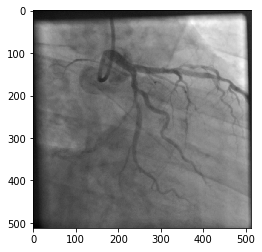

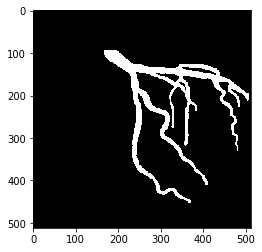

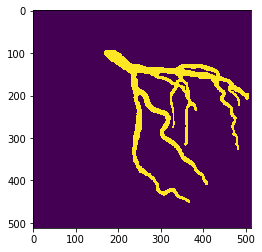

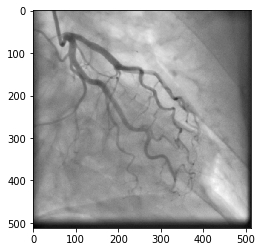

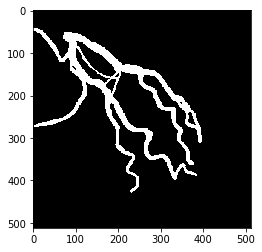

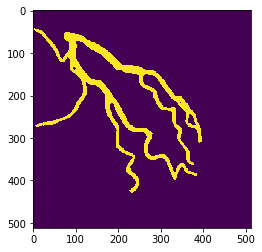

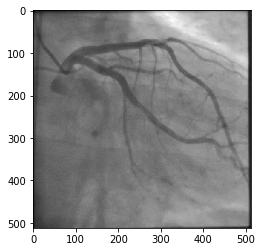

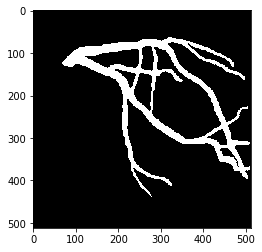

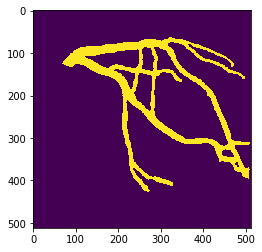

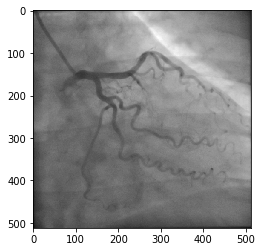

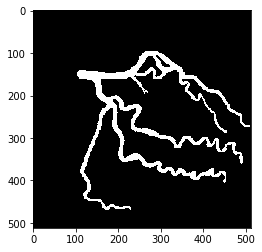

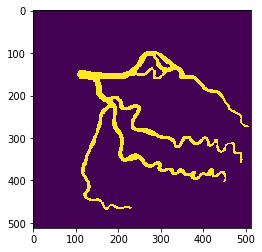

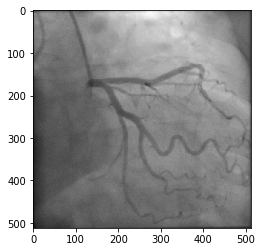

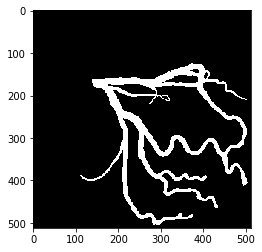

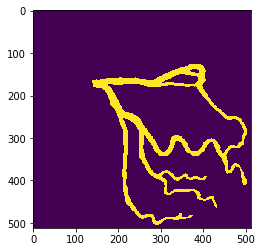

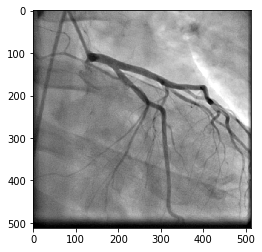

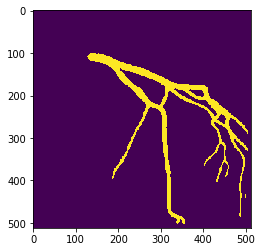

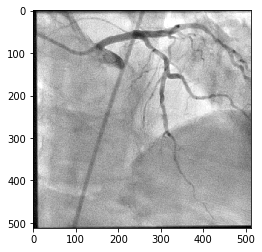

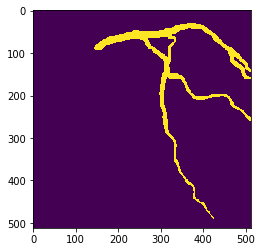

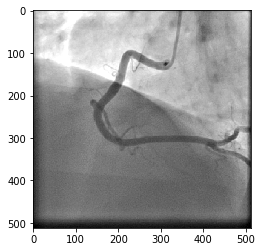

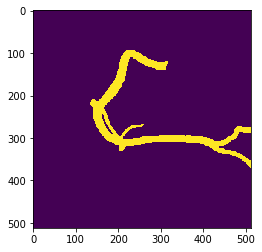

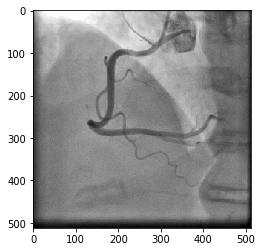

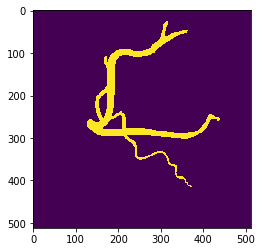

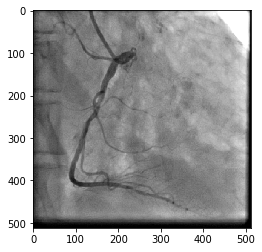

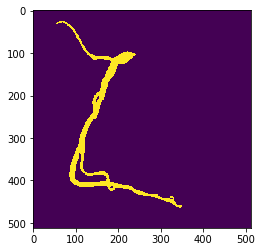

In [10]:
#@title Print segmented images

for i in range(10):
  sess = tf.Session()
  img = image_generator.next()
  label = mask_generator.next()

  plt.figure(); plt.imshow(np.squeeze(img), cmap="gray")
  if i < 5:
    plt.figure(); plt.imshow(np.squeeze(label), cmap="gray")
  full_sample = tf.nn.softmax(inference[i,:,:,:])
  pred = tf.argmax(full_sample, axis=-1)
  q = sess.run(pred)
  q = q.astype('uint8')
  plt.figure()
  plt.imshow(q)